In [1]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def generate_data(n):
    x1 = np.random.rand(n/2) * 10
    x2 = np.random.rand(n/2) * 10 + 20
    x = np.concatenate([x1, x2])
    y = np.sin(x)
    return x, y

/Library/Python/2.7/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


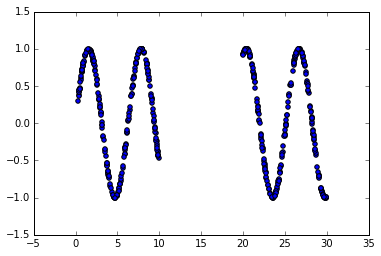

In [3]:
Ndata=500
data_x, data_y = generate_data(Ndata)
plt.scatter(data_x, data_y)
plt.show()

In [4]:
def linear(X, dout, name):
    with tf.variable_scope(name):
        _, dX = X.get_shape()
        W = tf.get_variable('W', shape=(dX, dout))
        b = tf.get_variable('b', shape=(dout))
    return tf.matmul(X, W)+b

def relu_layer(X, dout, name):
    return tf.nn.elu(linear(X, dout, name))

def ff_net(X, dout=1, layers=4, hidden_size=256):
    out = X
    for l in range(layers):
        out = relu_layer(out, dout=hidden_size, name='ff_%d'%l)
        out2 = tf.cos(out)  # Give some inductive bias so that it fits properly
        out = tf.concat(1, [out, out2])
    out = linear(out, dout=1, name='ff_final')
    return out


class FFnn(object):
    def __init__(self, name='ffnn'):
        self.name = name
        with tf.variable_scope(name):
            self.x_t = tf.placeholder(tf.float32, [None, 1], name='x')
            self.y_t = tf.placeholder(tf.float32, [None, 1], name='y')
            
            self.pred = ff_net(self.x_t)
            
            self.loss = tf.reduce_mean(tf.square(self.pred-self.y_t))
            self.train_step = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(self.loss)
    
    def fit(self, x, y, n=500, batch_size=32):
        print('beginning training %s' % self.name)
        N = x.shape[0]
        x = np.expand_dims(x, axis=1)
        y = np.expand_dims(y, axis=1)
        for i in range(n):
            bidx = np.random.randint(0, N, size=(batch_size,))
            _, loss = tf.get_default_session().run([self.train_step, self.loss], 
                                                   feed_dict={self.x_t: x[bidx], 
                                                              self.y_t: y[bidx]})
            if i % 200 == 0:
                print 'loss:', loss
    
    def predict(self, x):
        x = np.expand_dims(x, axis=1)
        return tf.get_default_session().run(self.pred, feed_dict={self.x_t: x})
            
            

In [5]:
tf.reset_default_graph()
sess = tf.Session()
nets = [FFnn(name='ffnn%d'%i) for i in range(10)]

with sess.as_default():
    sess.run(tf.initialize_all_variables())
    resamp_idx = np.random.randint(0, Ndata, size=(Ndata/2,))
    for net in nets:
        net.fit(data_x[resamp_idx], data_y[resamp_idx])

beginning training ffnn0
loss: 5.39719
loss: 0.000557472
loss: 0.000120662
beginning training ffnn1
loss: 2.35215
loss: 0.000159506
loss: 8.53078e-05
beginning training ffnn2
loss: 1.92007
loss: 0.000787366
loss: 0.000114492
beginning training ffnn3
loss: 0.942897
loss: 0.000269928
loss: 0.000166766
beginning training ffnn4
loss: 6.20773
loss: 0.000280826
loss: 8.02525e-05
beginning training ffnn5
loss: 12.1805
loss: 0.000220523
loss: 9.16748e-05
beginning training ffnn6
loss: 0.886486
loss: 0.00020402
loss: 0.000164184
beginning training ffnn7
loss: 17.5098
loss: 0.000386139
loss: 0.000160723
beginning training ffnn8
loss: 0.708436
loss: 0.000193841
loss: 4.62834e-05
beginning training ffnn9
loss: 1.31206
loss: 8.31012e-05
loss: 0.00344676


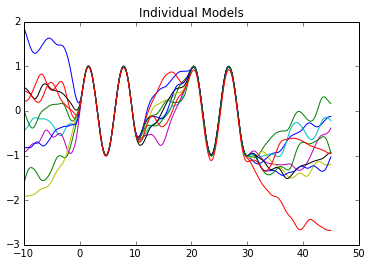

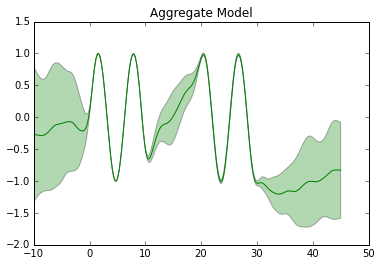

In [9]:
pred_x = np.linspace(-10, 50, num=400)
pred_ys = [None]*len(nets)
with sess.as_default():
    for i, net in enumerate(nets):
        pred_ys[i] = net.predict(pred_x)
pred_ys = np.array(pred_ys)[:,:,0]

mean_ys = np.mean(pred_ys, axis=0)
std_ys = np.std(pred_ys, axis=0)
for ys in (pred_ys):
    plt.plot(pred_x, ys)
plt.title('Individual Models')
plt.show()

plt.plot(pred_x, mean_ys, color='green')
plt.fill_between(pred_x, mean_ys-std_ys, mean_ys+std_ys ,alpha=0.3, facecolor='green')
plt.title('Aggregate Model')
plt.show()